<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一、持有A股流通市值" data-toc-modified-id="一、持有A股流通市值-1">一、持有A股流通市值</a></span></li><li><span><a href="#二、体量" data-toc-modified-id="二、体量-2">二、体量</a></span></li><li><span><a href="#三、申购赎回情况" data-toc-modified-id="三、申购赎回情况-3">三、申购赎回情况</a></span><ul class="toc-item"><li><span><a href="#1.主动权益基金新发行规模" data-toc-modified-id="1.主动权益基金新发行规模-3.1">1.主动权益基金新发行规模</a></span></li><li><span><a href="#2.公募基金申购" data-toc-modified-id="2.公募基金申购-3.2">2.公募基金申购</a></span></li><li><span><a href="#3.公募基金赎回" data-toc-modified-id="3.公募基金赎回-3.3">3.公募基金赎回</a></span></li></ul></li><li><span><a href="#四、仓位" data-toc-modified-id="四、仓位-4">四、仓位</a></span></li><li><span><a href="#五、成交金额" data-toc-modified-id="五、成交金额-5">五、成交金额</a></span></li><li><span><a href="#六、行业" data-toc-modified-id="六、行业-6">六、行业</a></span><ul class="toc-item"><li><span><a href="#1.前十大重仓股" data-toc-modified-id="1.前十大重仓股-6.1">1.前十大重仓股</a></span></li><li><span><a href="#2.行业持仓比例" data-toc-modified-id="2.行业持仓比例-6.2">2.行业持仓比例</a></span></li><li><span><a href="#3.超配比例" data-toc-modified-id="3.超配比例-6.3">3.超配比例</a></span></li></ul></li><li><span><a href="#七、风格结构" data-toc-modified-id="七、风格结构-7">七、风格结构</a></span></li></ul></div>

In [1]:
from it_data_tool.data_tool import *
from lowrisk_it_tools.WindPy import *
from macrotoolchain.mainAPI import *
di.display_html(getCatalogHtml(),raw=True)
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
di.HTML(getCatalogHtml())
h1Title('公募基金投资行为')
h2Title('更新时间： {}年{}月{}日'.format(Date.today().year, Date.today().month, Date.today().day))

公募基金投资行为

# 一、持有A股流通市值

计算方法：取全部初始基金，中国共同基金投资组合——资产配置：持有股票市值(元)-港股通投资港股市值，每季度按类别加总
+ 其他类为系统定义的主动FOF、主动债券、主动其他、主动美元债、主动货基、被动债券、被动商品，由于持股量较小，全部并入“其他”

In [2]:
# 所用日期序列
start_date = '20051231'
end_date = datetime.today().strftime('%Y%m%d')
date_list_base = pd.date_range(start_date,end_date,freq='Q')
date_list = [d.strftime('%Y%m%d') for d in date_list_base]

In [3]:
# A股流通市值
def cal_a_flow_nav():
    sql = '''
        select S_INFO_WINDCODE as scode, TRADE_DT, S_DQ_MV/1e4 as flow_market_value
        from ads_wind_AShareEODDerivativeIndicator_a
        where TRADE_DT in {}
        order by TRADE_DT, S_INFO_WINDCODE
        '''.format(tuple(date_list))
    df = get_quant_db_hz(sql).groupby(['trade_dt'])['flow_market_value'].sum()
    df.index = pd.to_datetime(df.index)
    return df

a_flow_nav = cal_a_flow_nav()

In [4]:
# 公募基金
def cal_fund_nav():
    # 基金名单
    sql = '''
        select fund_code as fcode, custom_first_type, custom_second_type
        from ads_fund_baseinfo_invest_a
        where is_initial = 1
        '''
    funds = get_quant_db_hz(sql)
    funds['type'] = funds['custom_first_type']+funds['custom_second_type']
    funds = funds[['fcode','type']]
    fund_list = funds['fcode'].tolist()
    # 基金持股市值
    sql = '''
        select S_INFO_WINDCODE as fcode, F_PRT_ENDDATE as trade_dt,
            F_PRT_STOCKVALUE/1e8 as fund_market_value, F_PRT_HKSTOCKVALUE/1e8 as hknav
        from ads_fund_ChinaMutualFundAssetPortfolio
        where S_INFO_WINDCODE in {} and F_PRT_ENDDATE in {}
        order by F_PRT_ENDDATE
        '''.format(tuple(fund_list),tuple(date_list))
    df = get_quant_db_hz(sql).fillna(0)
    df = pd.merge(df,funds,on=['fcode'])
    df['fund_market_value'] -= df['hknav']
    df = df.groupby(['trade_dt','type'])['fund_market_value'].sum().reset_index()
    df.trade_dt = pd.to_datetime(df.trade_dt)
    df = df.pivot_table(index=['trade_dt'],columns=['type'],values=['fund_market_value'])['fund_market_value'].fillna(0)
    df['其他'] = df[['主动FOF','主动债券','主动其他','主动美元债','主动货基','被动债券','被动商品']].sum(axis=1)
    df = df.drop(['主动FOF','主动债券','主动其他','主动美元债','主动货基','被动债券','被动商品'],axis=1)
    return df

fund_nav = cal_fund_nav()

In [5]:
nav = pd.concat([fund_nav,a_flow_nav],axis=1)
nav['fund_market_value'] = nav.iloc[:,:-1].sum(axis=1)
nav['占A股总流通市值之比'] = nav['fund_market_value']/nav['flow_market_value']*100
nav = nav.drop(['flow_market_value','fund_market_value'],axis=1)
nav = nav[['主动权益','被动权益','主动固收+','主动境外股票','被动境外股票','主动类平衡','其他','占A股总流通市值之比']]

In [6]:
from lowrisk.CustomECharts import *
colors = ['palevioletred','lightcoral','gold','limegreen','lightskyblue','violet','hotpink']
plot_arr = []

for i in range(0,len(nav.columns)-1):
    c = nav.columns[i]
    s = Data(timeList=nav.index,dataList=nav[c],title=c)
    bar_gra = barGraph(s,color=colors[i],stack='1')
    plot_arr.append(bar_gra)

s = Data(timeList=nav.index,dataList=nav['占A股总流通市值之比'],title='占A股总流通市值之比（%）')
line_gra = lineGraph(s,color='midnightblue',yAxisIndex=1)
plot_arr.append(line_gra)

goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = [setAxis(),setAxis()],
                            title=setTitle("公募基金持有A股流通市值（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 二、体量

计算方法：Wind EDB->公募基金净值分项、公募基金份额分项

In [7]:
guimo = w.edb("M5207872,M5207873,M5207874,M5207875,M5207876", start_date, end_date, usedf=True)[1]
guimo.columns = ['股票型','混合型','债券型','货币型','QDII']

In [8]:
from lowrisk.CustomECharts import *
colors = ['crimson','coral','gold','limegreen','lightskyblue']
plot_arr = []

for i in range(len(guimo.columns)):
    c = guimo.columns[i]
    s = Data(timeList=guimo.index,dataList=guimo[c],title=c)
    bar_gra = barGraph(s,color=colors[i],stack='1')
    plot_arr.append(bar_gra)
    
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("公募基金月度规模（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

In [9]:
fene = w.edb("M5207864,M5207865,M5207866,M5207867,M5207868", start_date, end_date, usedf=True)[1]
fene.columns = ['股票型','混合型','债券型','货币型','QDII']

In [10]:
from lowrisk.CustomECharts import *
colors = ['crimson','coral','gold','limegreen','lightskyblue']
plot_arr = []

for i in range(len(fene.columns)):
    c = fene.columns[i]
    s = Data(timeList=fene.index,dataList=fene[c],title=c)
    bar_gra = barGraph(s,color=colors[i],stack='1')
    plot_arr.append(bar_gra)
    
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("公募基金月度份额（亿份）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 三、申购赎回情况

## 1.主动权益基金新发行规模

计算方法：考察每只基金的发行份额，根据发行日期周度求和，得到周度的主动权益基金新发行规模；季度求和得到每季度的新发行总量

In [11]:
def get_fund_issue(sd):
    sql = '''
        select fund_code as fcode, setup_date, issue_total_unit
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '主动' and custom_second_type = '权益' and is_initial = '1' and setup_date >= '{}'
        order by setup_date
        '''.format(sd)
    df = get_quant_db_hz(sql).dropna()
    df.setup_date = pd.to_datetime(df.setup_date)
    df = df.set_index('setup_date')
    df1 = df.resample('W').sum()
    df2 = df.resample('Q').sum()
    return df1,df2

fund_issue_w,fund_issue_q = get_fund_issue(start_date)

In [12]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_issue_w.index,dataList=fund_issue_w['issue_total_unit'],title='周度')
line_gra = lineGraph(s,color='midnightblue')
s = Data(timeList=fund_issue_q.index,dataList=fund_issue_q['issue_total_unit'],title='季度')
bar_gra = barGraph(s,yAxisIndex=1,color='lightpink')
plot_arr = [bar_gra,line_gra]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = [setAxis(range=[0,2000]),setAxis()],
                            title=setTitle("主动权益基金新发行总规模（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

## 2.公募基金申购

计算方法：根据数据可得性及频率，分类非ETF基金和ETF基金分布计算。不包含新发行基金的规模
+ 对于非ETF基金，取每季度公布的基金合计份额作为当季度持有的份额，计算当季和上季度份额之差\*当季度和上季度净值均值，即为本季度的净申购金额。周度净申赎率来自中信证券报告
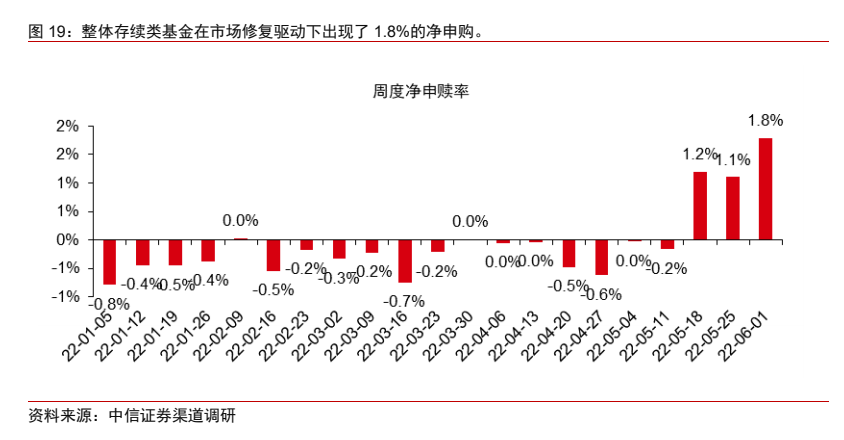
+ 对于ETF基金，每日均公布份额，计算每日份额变动\*当日净值，按照周度求和，即为周度的净申购金额；求解季度净申购金额作为参照

In [13]:
# 非ETF基金
def get_fund_netshares(sd,ed):
    sql = '''
        select fund_code as fcode
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '主动' and  custom_second_type = '权益' and is_initial = '1'
        order by fund_code
        '''.format(sd)
    df = get_quant_db_hz(sql).dropna()
    fund_code_list = df.fcode.tolist()
    # 份额（亿份）
    sql = '''
        select a.F_INFO_WINDCODE as fcode, a.CHANGE_DATE as ann_date, a.FUNDSHARE_TOTAL/10000 as share
        from ads_fund_ChinaMutualFundShare a
        where a.F_INFO_WINDCODE in {} and a.CHANGE_DATE >= '{}'
        order by a.F_INFO_WINDCODE, a.CHANGE_DATE
        '''.format(tuple(fund_code_list),sd)
    df = get_quant_db_hz(sql).dropna()
    df['ann_date'] = pd.to_datetime(df['ann_date'])
    sql1 = '''
        select F_INFO_WINDCODE as fcode,PRICE_DATE as ann_date, F_NAV_UNIT as nav
        from ads_fund_ChinaMutualFundNAV
        where F_INFO_WINDCODE in {} and PRICE_DATE >= '{}'
        order by f_info_windcode,price_date
        '''.format(tuple(fund_code_list),sd)
    nav = get_quant_db_hz(sql1)
    nav['ann_date'] = pd.to_datetime(nav['ann_date'])
    nav = nav.groupby(['fcode']).apply(lambda x:x.set_index(['ann_date']).resample('D').fillna(method='ffill')).drop(['fcode'],axis=1).reset_index()
    df = pd.merge(df,nav,on=['fcode','ann_date'])
    # 季度金额变动
    df1 = df.groupby(['fcode'])['share'].diff().dropna()
    df2 = df.groupby(['fcode'])['nav'].rolling(2,1).mean().dropna().reset_index().drop(['fcode','level_1'],axis=1)
    fund = pd.concat([df[['fcode','ann_date']],df1],axis=1).reset_index(drop=True)
    fund = pd.concat([fund,df2],axis=1).dropna()
    date_list = pd.date_range(sd,ed,freq='Q')
    fund = fund[fund.ann_date.isin(date_list)]
    fund['netbuy'] = fund['share']*fund['nav']
    return fund

fund_netshares = get_fund_netshares(start_date,end_date)

In [14]:
def cal_nettotal(df):
    df = df.copy()
    df = df.groupby(['ann_date'])['netbuy'].sum().reset_index()
    return df
fund_nettotal = cal_nettotal(fund_netshares)

In [15]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_nettotal['ann_date'],dataList=fund_nettotal['netbuy'],title='净申购金额（亿元）')
bar_gra = barGraph(s,color='palevioletred')
plot_arr = [bar_gra]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("主动权益基金季度净申购金额（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

In [16]:
# ETF基金
def get_fund_netshares(sd,ed):
    sql = '''
        select fund_code as fcode
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '被动' and custom_second_type = '权益' and custom_third_type = 'ETF' and is_initial = '1'
        order by fund_code
        '''.format(sd)
    df = get_quant_db_hz(sql).dropna()
    etf_code_list = df.fcode.tolist()
    
    # 份额（亿份）
    sql = '''
        select a.F_INFO_WINDCODE as fcode, a.CHANGE_DATE as ann_date, a.F_INFO_SHARE/10000 as share
        from ads_fund_ChinaMutualFundShare a
        where a.F_INFO_WINDCODE in {} and a.CHANGE_DATE >= '{}'
        order by a.F_INFO_WINDCODE, a.CHANGE_DATE
        '''.format(tuple(etf_code_list),sd)
    df = get_quant_db_hz(sql).dropna()
    df['ann_date'] = pd.to_datetime(df['ann_date'])
    sql1 = '''
        select F_INFO_WINDCODE as fcode,PRICE_DATE as ann_date, F_NAV_UNIT as nav
        from ads_fund_ChinaMutualFundNAV
        where F_INFO_WINDCODE in {}
        order by f_info_windcode,price_date
        '''.format(tuple(etf_code_list))
    nav = get_quant_db_hz(sql1)
    nav['ann_date'] = pd.to_datetime(nav['ann_date'])
    nav = nav.groupby(['fcode']).apply(lambda x:x.set_index(['ann_date']).resample('D').fillna(method='ffill')).drop(['fcode'],axis=1).reset_index()
    df = pd.merge(df,nav,on=['fcode','ann_date'])
    df1 = df.groupby(['fcode'])['share'].diff()
    df = pd.concat([df[['fcode','ann_date','nav']],df1],axis=1).dropna()
    df['netbuy'] = df['share']*df['nav']
    # 周度金额变动
    etf1 = df.drop(['share','nav'],axis=1).groupby(['fcode']).apply(lambda x:x.set_index('ann_date').resample('W').sum()).reset_index()
    # 季度金额变动
    etf2 = df.drop(['share','nav'],axis=1).groupby(['fcode']).apply(lambda x:x.set_index('ann_date').resample('Q').sum()).reset_index()
    return etf1,etf2

etf_netshares_w,etf_netshares_q = get_fund_netshares(start_date,end_date)

In [17]:
etf_nettotal_w = cal_nettotal(etf_netshares_w)
etf_nettotal_q = cal_nettotal(etf_netshares_q)

from lowrisk.CustomECharts import *
s = Data(timeList=etf_nettotal_w['ann_date'],dataList=etf_nettotal_w['netbuy'],title='周度')
line_gra = lineGraph(s,color='midnightblue')
s = Data(timeList=etf_nettotal_q['ann_date'],dataList=etf_nettotal_q['netbuy'],title='季度')
bar_gra = barGraph(s,yAxisIndex=1,color='lightpink')
plot_arr = [bar_gra,line_gra]

goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = [setAxis(range=[-610,610]),setAxis(range=[-1400,1400])],
                            title=setTitle("权益ETF净申购金额"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

## 3.公募基金赎回

计算方法：按照主动权益基金、ETF基金分类，分别统计季度、周度赎回的产品占全部产品的百分数

In [18]:
# 赎回的金额、赎回率
def cal_back_pctchg(df):
    df = df.copy()
    df = df.assign(tot_cnt = lambda x:x.groupby(['ann_date'])['fcode'].transform('count'))
    df = df[df.netbuy<0]
    df = df.assign(back = lambda x:x.groupby(['ann_date'])['fcode'].transform('count'))
    df = df[['ann_date','tot_cnt','back']].drop_duplicates()
    df = df.sort_values(['ann_date'])
    df['back'] /= df['tot_cnt']
    return df.set_index('ann_date')[['back']]

fund_back_pctchg = cal_back_pctchg(fund_netshares)
etf_back_pctchg_w = cal_back_pctchg(etf_netshares_w)
etf_back_pctchg_q = cal_back_pctchg(etf_netshares_q)

In [19]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_back_pctchg.index,dataList=fund_back_pctchg['back'],title='主动权益基金季度赎回率')
line_gra1 = lineGraph(s,color='midnightblue')
s = Data(timeList=etf_back_pctchg_w.index,dataList=etf_back_pctchg_w['back'],title='权益ETF周度赎回率')
line_gra2 = lineGraph(s,color='palevioletred')
s = Data(timeList=etf_back_pctchg_q.index,dataList=etf_back_pctchg_q['back'],title='权益ETF季度赎回率')
line_gra3 = lineGraph(s,color='coral')

plot_arr = [line_gra1,line_gra2,line_gra3]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("主动&被动权益基金赎回率"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 四、仓位

计算方法
+ 仓位：主动权益型基金每季度持有股票市值占资产净值比例按照市值加权平均
+ 基金持股市值集中度：持股市值位于前5%基金持股市值之和/全部基金持股市值之和

In [20]:
def get_fund_cangwei(sd,ed):
    sql = '''
        select fund_code as fcode
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '主动' and  custom_second_type = '权益' and is_initial = '1'
        order by fcode
        '''
    df = get_quant_db_hz(sql).dropna()
    fund_code_list = df.fcode.tolist()
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select S_INFO_WINDCODE as fcode, F_PRT_ENDDATE as ann_date, F_PRT_STOCKTONAV as stock_ratio, F_PRT_NETASSET as nav,
            F_PRT_STOCKVALUE as stockval, F_PRT_HKSTOCKVALUE as hkstockval
        from ads_fund_ChinaMutualFundAssetPortfolio
        where S_INFO_WINDCODE in {} and F_PRT_ENDDATE in {}
        order by S_INFO_WINDCODE,F_PRT_ENDDATE
        '''.format(tuple(fund_code_list),tuple(date_list))
    df = get_quant_db_hz(sql).fillna(0)
    df.ann_date = pd.to_datetime(df.ann_date)
    
    # 基金持股市值集中度
    df1 = df.copy()
    df1 = df1.assign(rank = lambda x:x.groupby(['ann_date'])['stockval'].rank(ascending=False),
                    tot_num = lambda x:x.groupby(['ann_date'])['fcode'].transform('count'),
                    tot_nav = lambda x:x.groupby(['ann_date'])['stockval'].transform('sum'))
    df1['pct'] = df1['rank']/df1['tot_num']
    df1 = df1[df1['pct']<=0.05]
    df1 = df1.assign(top_nav = lambda x:x.groupby(['ann_date'])['stockval'].transform('sum'))
    df1['jizhongdu'] = df1['top_nav']/df1['tot_nav']*100
    df1 = df1[['ann_date','jizhongdu']].drop_duplicates()
    df1.ann_date = pd.to_datetime(df1.ann_date)
    df1 = df1.sort_values(['ann_date']).set_index('ann_date')
    
    # 仓位拆分
    df['astockval'] = df['stockval'] - df['hkstockval']
    df['aratio'] = df['astockval'] / df['nav']
    df['hkratio'] = df['hkstockval'] / df['nav']
    # 基金市值加权
    df = df.assign(tot_nav = lambda x:x.groupby(['ann_date'])['nav'].transform('sum'),
                   w = lambda x:x['nav']/x['tot_nav'])
    df['tot_cangwei'] = df['w']*df['stock_ratio']
    df['a_cangwei'] = df['w']*df['aratio']
    df['hk_cangwei'] = df['w']*df['hkratio']
    df = df.groupby(['ann_date'])[['tot_cangwei','a_cangwei','hk_cangwei']].sum()
    df['a_cangwei'] *= 100
    df['hk_cangwei'] *= 100
    return df,df1

fund_cangwei,fund_jzd = get_fund_cangwei(start_date,end_date)

In [21]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_cangwei.index,dataList=fund_cangwei['tot_cangwei'].tolist(),title='股票仓位（%）')
line_gra = lineGraph(s,color='midnightblue')
s = Data(timeList=fund_cangwei.index,dataList=fund_cangwei['a_cangwei'].tolist(),title='A股仓位（%）')
bar_gra1 = barGraph(s,color='plum',stack='1')
s = Data(timeList=fund_cangwei.index,dataList=fund_cangwei['hk_cangwei'].tolist(),title='H股仓位（%）')
bar_gra2 = barGraph(s,color='palevioletred',stack='1')
plot_arr = [line_gra,bar_gra1,bar_gra2]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("主动权益基金季度市值加权平均仓位"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

In [22]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_jzd.index,dataList=fund_jzd['jizhongdu'].tolist(),title='集中度（%）')
line_gra = lineGraph(s,color='midnightblue')
plot_arr = [line_gra]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("基金持股市值集中度"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 五、成交金额

计算方法：中国共同基金持有人结构->报告期买入股票成本总额(元)-报告期卖出股票收入总额(元)，对于全部主动权益基金求和

In [23]:
def get_fund_trade(sd,ed):
    sql = '''
        select fund_code as fcode
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '主动' and  custom_second_type = '权益' and is_initial = '1'
        order by fcode
        '''
    df = get_quant_db_hz(sql).dropna()
    fund_code_list = df.fcode.tolist()
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select S_INFO_WINDCODE as scode, END_DT as ann_date, PUR_COST/1e8 as buy, SELL_INCOME/1e8 as sell
        from ads_fund_CMFHolderStructure_a
        where END_DT in {} and S_INFO_WINDCODE in {}
        order by END_DT
        '''.format(tuple(date_list),tuple(fund_code_list))
    df = get_quant_db_hz(sql).dropna()
    df.ann_date = pd.to_datetime(df.ann_date)
    df['chengjiao'] = df['buy']-df['sell']
    df = df.groupby(['ann_date'])['chengjiao'].sum()
    return df

fund_trade = get_fund_trade(start_date,end_date)

In [24]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_trade.index,dataList=fund_trade.tolist(),title='成交额（亿元）')
line_gra = lineGraph(s,color='midnightblue')
plot_arr = [line_gra]
goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("主动权益基金成交额"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 六、行业

## 1.前十大重仓股

计算方法：对于市场上所有成立时间超过180天的主动权益基金的持仓，找合计持股市值最大的前10只股票，作为持股金额

In [25]:
def get_fund_portfolio(sd,ed):
    new_ed = datetime.strptime(ed,'%Y%m%d')-timedelta(180)
    new_ed = new_ed.strftime('%Y%m%d')
    sql = '''
        select fund_code as fcode
        from ads_fund_baseinfo_invest_a
        where custom_first_type = '主动' and  custom_second_type = '权益' and is_initial = '1' and setup_date <= '{}'
        order by fcode
        '''.format(new_ed)
    df = get_quant_db_hz(sql).dropna()
    fund_code_list = df.fcode.tolist()
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    # 持仓明细（含行业）
    sql = '''
        select a.S_INFO_WINDCODE as fcode, a.F_PRT_ENDDATE as ann_date, a.S_INFO_STOCKWINDCODE as scode,
            a.F_PRT_STKVALUE as svalue, a.F_PRT_STKVALUETONAV as sratio, b.F_PRT_STOCKVALUE as nav
        from ads_fund_ChinaMutualFundStockPortfolio a
            join ads_fund_ChinaMutualFundAssetPortfolio b
            on a.S_INFO_WINDCODE=b.S_INFO_WINDCODE and a.F_PRT_ENDDATE=b.F_PRT_ENDDATE
        where a.S_INFO_WINDCODE in {} and a.F_PRT_ENDDATE in {}
        '''.format(tuple(fund_code_list),tuple(date_list))
    df = get_quant_db_hz(sql).dropna()
    sql = '''
        select wind_code as scode, citic_industry as industry
        from ads_wind_ahshareciticsindustries_style_a
        '''
    ind = get_quant_db_hz(sql)
    df = pd.merge(df,ind,on=['scode'],how='left')
    df['industry'] = df['industry'].fillna('综合')
    df.ann_date = pd.to_datetime(df.ann_date)
    # 行业和中信一级行业对齐
    df.loc[df.industry=='保险Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='证券Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='多元金融','industry'] = '非银行金融'
    df.loc[df.industry=='酒类','industry'] = '食品饮料'
    df.loc[df.industry=='食品','industry'] = '食品饮料'
    df.loc[df.industry=='饮料','industry'] = '食品饮料'
    return df

fund_portfolio = get_fund_portfolio(start_date,end_date)

In [26]:
def cal_top10(df):
    df = df.copy()
    df = df.groupby(['ann_date','scode'])['svalue'].sum().reset_index()
    df = df.assign(rank = lambda x:x.groupby(['ann_date'])['svalue'].rank(ascending=False,method='first'))
    df = df[df['rank']<=10]
    # 股票名称
    name_list = df.scode.drop_duplicates().tolist()
    sql = '''
        select s_info_windcode as scode, s_info_name as sname
        from ads_wind_asharedescription_a
        where s_info_windcode in {}
        '''.format(tuple(name_list))
    names = get_quant_db_hz(sql)
    sql = '''
        select s_info_windcode as scode, s_info_name as sname
        from ads_wind_hksharedescription_a
        where s_info_windcode in {}
        '''.format(tuple(name_list))
    names1 = get_quant_db_hz(sql)
    names = pd.concat([names,names1],axis=0)
    df = pd.merge(df,names,on=['scode']).sort_values(['ann_date','rank'])
    df['svalue'] /= 1e8
    return df

fund_top10 = cal_top10(fund_portfolio)

In [27]:
from lowrisk.CustomECharts import *
date_range = sorted(list(set(fund_top10['ann_date'].tolist())))
rank_range = sorted(list(set(fund_top10['rank'].tolist())))
colors = ['crimson','darkorange','gold','mediumaquamarine','lightskyblue','dodgerblue','slateblue','violet','hotpink','mediumvioletred']
plot_arr = []
for i in range(len(rank_range)):
    r = rank_range[i]
    df = fund_top10[fund_top10['rank']==r].sort_values(['ann_date'])
    s = Data(timeList=df.ann_date.tolist(),dataList=df.svalue.tolist(),title='top{}'.format(i+1))
    bar_gra = barGraph(s,color=colors[i],label={'position':'insideTop',
                                                'show': True,
                                                'rotate':60,
                                                'formatter':'{@[2]}',
                                                'align':'left',
                                                'verticalAlign':'middle'
                                               })
    for i in range(len(bar_gra['data'])):
        bar_gra['data'][i].append(df.sname.tolist()[i])
    plot_arr.append(bar_gra)

goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("主动权益基金季度前十大重仓股持有总市值（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

## 2.行业持仓比例

计算方法：将基金每季度能够得到的股票看作股票组合，季报则将前10大重仓股持仓市值根据当期持有股票总市值进行按比例放大，分别对齐行业（含A股、H股），各行业的股票市值比求和

In [28]:
# 行业持仓比例
# 差异：zty用的基金持仓补过仓，苯人这里只用了季报里面有的
def cal_ind_ratio(df):
    df = df.assign(sratio_tot = lambda x:x.groupby(['fcode','ann_date'])['sratio'].transform('sum'),
                  sratio = lambda x:x['sratio']/x['sratio_tot'])
    df['svalue'] = df['sratio']*df['nav']
    df = df.assign(tot_value = lambda x:x.groupby(['ann_date'])['svalue'].transform('sum'),
                   ind_value = lambda x:x.groupby(['ann_date','industry'])['svalue'].transform('sum'),
                   ind_ratio = lambda x:x['ind_value']/x['tot_value'])
    df = df[['ann_date','industry','ind_ratio']].pivot_table(index=['ann_date'],columns=['industry'],values=['ind_ratio'])['ind_ratio']
    df = df*100
    return df

fund_ind_df = cal_ind_ratio(fund_portfolio)

In [29]:
bankuai = {'上游周期':['石油石化','基础化工','煤炭','钢铁','有色金属','建筑','建材','农林牧渔'],
           '中游制造':['电力及公用事业','电力设备及新能源','汽车','机械','交通运输','轻工制造','国防军工'],
           '大消费':['商贸零售','食品饮料','纺织服装','家电','消费者服务','医药'],
           'TMT':['电子','计算机','通信','传媒'],
           '金融地产':['银行','非银行金融','房地产','综合金融'],
           '其他':['综合']}
dabankuai = ['上游周期','中游制造','大消费','TMT','金融地产','其他']

In [30]:
def draw(name):
    df = fund_ind_df[bankuai[name]].copy()
    plot_arr = []
    for i in range(len(df.columns)):
        column = df.columns[i]
        color = colors[i]
        s = Data(timeList=df.index,dataList=df[column].tolist(),title=column)
        line_gra = lineGraph(s,color=color)
        plot_arr.append(line_gra)
    g = goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                                    yAxis = setAxis(range=[0,30]),
                                    title=setTitle("主动权益基金{}板块季度持仓比例（%）".format(name)),
                                    legend=dict(
                                                x="center",
                                                y="bottom",
                                                orient='horizontal',
                                                padding=[0,50,0,0]
                                                ),
                                    grid=[{
                                            "left":"5%",
                                            "right":"10%",
                                            "height":"70%"
                                        }],
                                    dataZoom=[
                                                {
                                                    "type":"slider",
                                                    "xAxisIndex":0,
                                                    "f'selector':TrueilterMode":'empty',
                                                    "bottom":"8%"
                                                },
                                                {
                                                    "type":"slider",
                                                    "yAxisIndex":0,
                                                    "filterMode":'empty'
                                                },
                                            ]
                                   )
                )
    return g

graphs = []
for name in dabankuai:
    graphs.append(draw(name))

In [31]:
graphs[0]

In [32]:
graphs[1]

In [33]:
graphs[2]

In [34]:
graphs[3]

In [35]:
graphs[4]

In [36]:
graphs[5]

## 3.超配比例

计算方法：计算各个行业在A股自由流通市值中的比例，再计算各个行业在公募基金持仓中的比例，计算两者之差

In [37]:
def get_ashares_nav(sd,ed):
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select s_info_windcode as scode, trade_dt as ann_date, s_dq_mv as nav
        from ads_wind_ashareeodderivativeindicator_a
        where trade_dt in {}
        '''.format(tuple(date_list))
    df = get_quant_db_hz(sql)
    sql = '''
        select wind_code as scode, citic_industry as industry
        from ads_wind_ahshareciticsindustries_style_a
        '''
    ind = get_quant_db_hz(sql)
    df = pd.merge(df,ind,on=['scode'],how='left')
    df['industry'] = df['industry'].fillna('综合')
    df.ann_date = pd.to_datetime(df.ann_date)
    df = df.dropna()
    # 行业和中信一级行业对齐
    df.loc[df.industry=='保险Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='证券Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='多元金融','industry'] = '非银行金融'
    df.loc[df.industry=='酒类','industry'] = '食品饮料'
    df.loc[df.industry=='食品','industry'] = '食品饮料'
    df.loc[df.industry=='饮料','industry'] = '食品饮料'
    return df
ashares_nav = get_ashares_nav(start_date,end_date)

In [38]:
def cal_excess(df1,df2):
    ashares_nav_tot = df1.groupby(['ann_date','industry'])['nav'].sum().reset_index().sort_values(['ann_date'])
    ashares_nav_tot['nav'] /= 1e8
    ashares_nav_tot = ashares_nav_tot.assign(tot = lambda x:x.groupby(['ann_date'])['nav'].transform('sum'),
                                             nav = lambda x:x['nav']/x['tot'])
    fund_nav_tot = df2.groupby(['ann_date','industry'])['svalue'].sum().reset_index().sort_values(['ann_date'])
    fund_nav_tot['svalue'] /= 1e8
    fund_nav_tot = fund_nav_tot.assign(tot = lambda x:x.groupby(['ann_date'])['svalue'].transform('sum'),
                                       svalue = lambda x:x['svalue']/x['tot'])
    excess = pd.merge(fund_nav_tot,ashares_nav_tot,on=['ann_date','industry'])
    excess['excess'] = excess['svalue'] - excess['nav']
    excess = excess[['ann_date','industry','excess']].pivot_table(index=['ann_date'],columns=['industry'],values=['excess'])['excess']
    excess = excess*100
    return excess

excess = cal_excess(ashares_nav,fund_portfolio)

In [39]:
def draw(name):
    df = excess[bankuai[name]].copy()
    plot_arr = []
    for i in range(len(df.columns)):
        column = df.columns[i]
        color = colors[i]
        s = Data(timeList=df.index,dataList=df[column].tolist(),title=column)
        line_gra = lineGraph(s,color=color)
        plot_arr.append(line_gra)
    g = goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                                    yAxis = setAxis(range=[-20,20]),
                                    title=setTitle("主动权益基金{}板块季度超配比例（%）".format(name)),
                                    legend=dict(
                                                x="center",
                                                y="bottom",
                                                orient='horizontal',
                                                padding=[0,50,0,0]
                                                ),
                                    grid=[{
                                            "left":"5%",
                                            "right":"10%",
                                            "height":"70%"
                                        }],
                                    dataZoom=[
                                                {
                                                    "type":"slider",
                                                    "xAxisIndex":0,
                                                    "f'selector':TrueilterMode":'empty',
                                                    "bottom":"8%"
                                                },
                                                {
                                                    "type":"slider",
                                                    "yAxisIndex":0,
                                                    "filterMode":'empty'
                                                },
                                            ]
                                   )
                )
    return g

graphs = []
for name in dabankuai:
    graphs.append(draw(name))

In [40]:
graphs[0]

In [41]:
graphs[1]

In [42]:
graphs[2]

In [43]:
graphs[3]

In [44]:
graphs[4]

In [45]:
graphs[5]

# 七、风格结构

计算方法：计算主动权益基金所有股票按照市值加权的PE、PB

In [46]:
def get_pepb(df,sd,ed):
    stock_list = list(set(df.scode.tolist()))
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select s_info_windcode as scode,trade_dt as ann_date,s_val_pe_ttm as pe,s_val_pb_new as pb
        from ads_wind_ashareeodderivativeindicator_a
        where s_info_windcode in {} and trade_dt in {}
        '''.format(tuple(stock_list),tuple(date_list))
    df1 = get_quant_db_hz(sql)
    sql = '''
        select s_info_windcode as scode,financial_trade_dt as ann_date,s_val_pe_ttm as pe,s_val_pb_new as pb
        from ads_wind_hkshareeodderivativeindex_a
        where s_info_windcode in {} and financial_trade_dt in {}
        '''.format(tuple(stock_list),tuple(date_list))
    df2 = get_quant_db_hz(sql)
    df = pd.concat([df1,df2],axis=0)
    df.ann_date = pd.to_datetime(df.ann_date)
    return df

pepb = get_pepb(fund_portfolio,start_date,end_date)

In [47]:
def cal_fund_pepb(df,tmp):
    df = df.copy()
    df = df.groupby(['ann_date','scode'])['svalue'].sum().reset_index()
    df = df.assign(tot_nav = lambda x:x.groupby(['ann_date'])['svalue'].transform('sum'),
                  svalue = lambda x:x['svalue']/x['tot_nav'])
    df = df.drop(['tot_nav'],axis=1)
    df = pd.merge(df,tmp,on=['scode','ann_date'])
    df['pe'] *= df['svalue']
    df['pb'] *= df['svalue']
    df = df.groupby(['ann_date'])[['pe','pb']].sum().reset_index()
    return df

fund_pepb = cal_fund_pepb(fund_portfolio,pepb)

In [48]:
from lowrisk.CustomECharts import *
s = Data(timeList=fund_pepb.ann_date.tolist(),dataList=fund_pepb['pe'].tolist(),title='PE')
line_gra1 = lineGraph(s,color='midnightblue')
s = Data(timeList=fund_pepb.ann_date.tolist(),dataList=fund_pepb['pb'].tolist(),title='PB')
line_gra2 = lineGraph(s,color='palevioletred',yAxisIndex=1)
plot_arr = [line_gra1,line_gra2]

goechart(plot_arr,
         setLayout(xAxis = setAxis(type="time"),
                   yAxis=[
                            setAxis(title='PE'),
                            setAxis(title='PB',range=[0,50])
                         ],
                   title=setTitle("主动权益基金市值加权估值"),
                   legend=dict(
                                x="center",
                                y="bottom",
                                orient='horizontal',
                                padding=[0,50,0,0]
                                ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )